In [1]:
import os
from pmlb import fetch_data
from sklearn.model_selection import KFold, ParameterGrid, ParameterSampler, StratifiedKFold, train_test_split, StratifiedShuffleSplit, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import log_loss, mean_squared_error, roc_auc_score, r2_score
from sklearn.base import clone
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils import check_random_state
from xgboost import XGBClassifier, XGBRegressor
from sklearn.svm import SVC, SVR
from interpret.glassbox import ExplainableBoostingClassifier, ExplainableBoostingRegressor
import numpy as np
from gplearn.gplearn.genetic import SymbolicRegressor, SymbolicClassifier
from gplearn.gplearn.model import ShapeNN
import time
from datetime import datetime
import pickle
import argparse
import operator
import functools
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

import scipy

from benchmarks import categorical_variables_per_dataset, score, load_df

from pygam import LinearGAM, LogisticGAM, s, f, te, l, GAM


In [2]:


def run_experiment_pygam(terms, dataset_name, task, random_state, return_model=False):

    df = pd.DataFrame(columns=['dataset','model','fold','score','time','timestamp'])

    timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")

    model_name = 'pygam'

    file_name = f"{dataset_name}_{model_name}_{timestamp}.csv"

    file_path = os.path.join('results',file_name)

    random_state = check_random_state(random_state)
    dataset = load_df(dataset_name,task)
    X = dataset.drop(columns=['target'])
    y = dataset[['target']]

    # y_max = y.max()
    # y_min = y.min()

    # y = (y-y_min)/(y_max-y_min)

    # First, we choose a validation set for hyper-parameter tuning
    if task == 'classification':
        sss = StratifiedShuffleSplit(n_splits=1, test_size=0.09, random_state=random_state)
        train_index, val_index = next(sss.split(X,y))
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    elif task == 'regression':
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.09, random_state=random_state)

    categorical_variables = categorical_variables_per_dataset[dataset_name]
    is_cat = np.array([i in categorical_variables for i in range(len(X.columns))])

    cat_cols = X.columns.values[is_cat]
    num_cols = X.columns.values[~is_cat]

    
    categories = []
    for i in categorical_variables:
        uniques = list(X.iloc[:,i].unique())
        categories.append(sorted(uniques))
    
    cat_pipe = Pipeline([('ordinal', OrdinalEncoder(categories=categories))])
    num_pipe = Pipeline([('std',StandardScaler())])
    transformers = [
        ('cat', cat_pipe, cat_cols),
        ('num', num_pipe, num_cols)
    ]
    ct = ColumnTransformer(transformers=transformers)
    
    processing = Pipeline([
        ('ct',ct),
    ])

    if task == 'classification':
        # Identity transformer for classification
        y_scaler = FunctionTransformer(lambda x: x.values)
    else:
        y_scaler = StandardScaler()

    if task == 'classification':
        splitter = StratifiedKFold(n_splits=10,shuffle=True,random_state=random_state)
    else:
        splitter = KFold(n_splits=10,shuffle=True,random_state=random_state)

    best_params = None
    cv_scores = []

    for i, (train_index, test_index) in tqdm(enumerate(splitter.split(X_train,y_train))):

        time_start = time.time()
        
        X_cv_train, y_cv_train = X_train.iloc[train_index], y_train.iloc[train_index]
        X_cv_test, y_cv_test = X_train.iloc[test_index], y_train.iloc[test_index]

        X_cv_train = processing.fit_transform(X_cv_train)
        y_cv_train = y_scaler.fit_transform(y_cv_train)[:,0]

        X_cv_test = processing.transform(X_cv_test)
        y_cv_test = y_scaler.transform(y_cv_test)[:,0]
        
        model = LinearGAM(terms, lam=0.1, fit_intercept=True, max_iter=1000, tol=1e-4, verbose=False)
        
        if best_params is not None:
            model.set_params(**best_params)

        model.fit(X_cv_train, y_cv_train)
        new_score = score(model,X_cv_test,y_cv_test,task)
        cv_scores.append(new_score)
        print(cv_scores)

        time_end = time.time()

        # Check if model has timestamp parameter
        if hasattr(model, 'timestamp'):
            fold_timestamp = model.timestamp
        else:
            fold_timestamp = "Not available"

        # Create a new dataframe row
        new_df_row = pd.DataFrame({
            'dataset': [dataset_name],
            'model': [model_name],
            'fold': [i],
            'score': [new_score],
            'time': [time_end-time_start],
            'timestamp':[fold_timestamp]
        })
        # Append the new row to the dataframe
        df = pd.concat([df, new_df_row], ignore_index=True)
        df.to_csv(file_path)
    
    if return_model:
        return np.mean(cv_scores), np.std(cv_scores), model
    return np.mean(cv_scores), np.std(cv_scores)

In [5]:
args = {'n_splines':10,
        'spline_order':3}
terms = f(0) + f(1) + s(2,**args) + s(3,**args) + s(4,**args) + s(5,**args) + s(6,**args) + s(7,**args) + s(8,**args) + s(9,**args) + s(10,**args) + s(11,**args) + s(12,**args)
mean, std, model = run_experiment_pygam(terms,'boston','regression',random_state=42,return_model=True)

4it [00:00, 16.72it/s]

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=1000, scale=None, 
   terms=f(0) + f(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10) + s(11) + s(12) + intercept,
   tol=0.0001, verbose=False) | score: <function score at 0x000001E33E338430>
[0.8771489878354155]
LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=1000, scale=None, 
   terms=f(0) + f(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10) + s(11) + s(12) + intercept,
   tol=0.0001, verbose=False) | score: <function score at 0x000001E33E338430>
[0.8771489878354155, 0.7928596391831739]
LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=1000, scale=None, 
   terms=f(0) + f(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10) + s(11) + s(12) + intercept,
   tol=0.0001, verbose=False) | score: <function score at 0x000001E33E338430>
[0.8771489878354155, 0.7928596391831739, 0.8149102781351734]
LinearGAM(callba

6it [00:00, 12.62it/s]

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=1000, scale=None, 
   terms=f(0) + f(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10) + s(11) + s(12) + intercept,
   tol=0.0001, verbose=False) | score: <function score at 0x000001E33E338430>
[0.8771489878354155, 0.7928596391831739, 0.8149102781351734, 0.8626292198803017, 0.7925676277958968]
LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=1000, scale=None, 
   terms=f(0) + f(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10) + s(11) + s(12) + intercept,
   tol=0.0001, verbose=False) | score: <function score at 0x000001E33E338430>
[0.8771489878354155, 0.7928596391831739, 0.8149102781351734, 0.8626292198803017, 0.7925676277958968, 0.7537231316785092]


8it [00:00, 14.27it/s]

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=1000, scale=None, 
   terms=f(0) + f(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10) + s(11) + s(12) + intercept,
   tol=0.0001, verbose=False) | score: <function score at 0x000001E33E338430>
[0.8771489878354155, 0.7928596391831739, 0.8149102781351734, 0.8626292198803017, 0.7925676277958968, 0.7537231316785092, 0.8382114008349284]
LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=1000, scale=None, 
   terms=f(0) + f(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10) + s(11) + s(12) + intercept,
   tol=0.0001, verbose=False) | score: <function score at 0x000001E33E338430>
[0.8771489878354155, 0.7928596391831739, 0.8149102781351734, 0.8626292198803017, 0.7925676277958968, 0.7537231316785092, 0.8382114008349284, 0.7972072603275009]
LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=1000, scale=None, 
   terms=f(0) + f(1) + s(2) +

10it [00:00, 12.59it/s]

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=1000, scale=None, 
   terms=f(0) + f(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10) + s(11) + s(12) + intercept,
   tol=0.0001, verbose=False) | score: <function score at 0x000001E33E338430>
[0.8771489878354155, 0.7928596391831739, 0.8149102781351734, 0.8626292198803017, 0.7925676277958968, 0.7537231316785092, 0.8382114008349284, 0.7972072603275009, 0.7245187600862919, 0.8931761455222696]


In [6]:
mean

0.8146952451279462

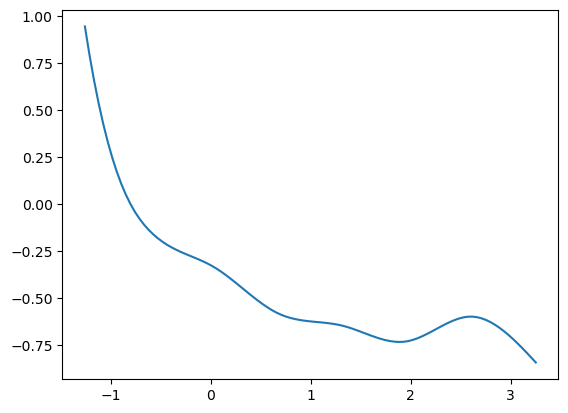

In [14]:
i = 8


In [18]:
def plot_pygam(axs, i, offset=2):
    ax = axs[i]
    XX = model.generate_X_grid(term=i+offset)
    ax.plot(XX[:,i+offset],model.partial_dependence(term=i+offset, X=XX))


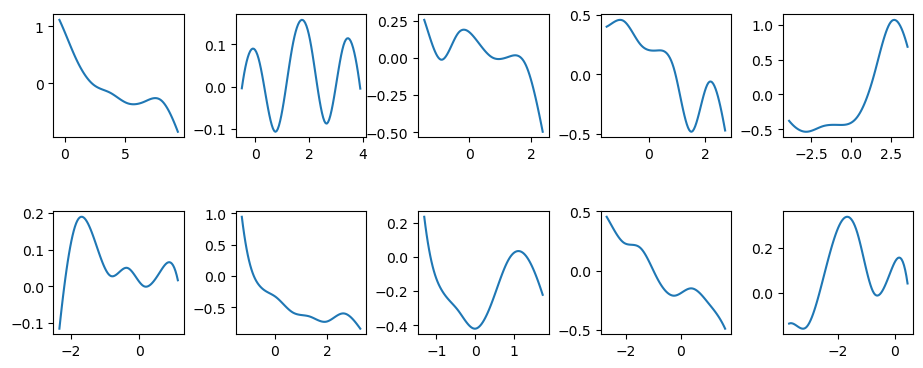

In [20]:
fig, axs = plt.subplots(2, 5, figsize=(10, 4))
axs = axs.flatten()
for i in range(10):
    plot_pygam(axs, i, offset=2)
plt.tight_layout()
plt.subplots_adjust(left=0.12, bottom=0.1, right=0.98, top=0.9, wspace=0.4, hspace=0.6)

In [59]:
args = {'n_splines':10,
        'spline_order':3}
terms = s(0, **args) + s(1, **args) + s(2,**args) + s(3,**args) + s(4,**args) + s(5,**args) + s(6,**args) + s(7,**args)
mean, std, model = run_experiment_pygam(terms,'concrete','regression',random_state=42,return_model=True)

5it [00:00, 22.03it/s]

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=1000, scale=None, 
   terms=s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + intercept,
   tol=0.0001, verbose=False) | score: <function score at 0x0000023278F39160>
[0.8625257226211465]
LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=1000, scale=None, 
   terms=s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + intercept,
   tol=0.0001, verbose=False) | score: <function score at 0x0000023278F39160>
[0.8625257226211465, 0.8583351169431392]
LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=1000, scale=None, 
   terms=s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + intercept,
   tol=0.0001, verbose=False) | score: <function score at 0x0000023278F39160>
[0.8625257226211465, 0.8583351169431392, 0.8699533095875599]
LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=1000, scale=None, 
   terms=s(0) + s(1) + s(2) + s(3) 

10it [00:00, 21.36it/s]

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=1000, scale=None, 
   terms=s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + intercept,
   tol=0.0001, verbose=False) | score: <function score at 0x0000023278F39160>
[0.8625257226211465, 0.8583351169431392, 0.8699533095875599, 0.898984180888886, 0.8888528430054496, 0.9043927119544737]
LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=1000, scale=None, 
   terms=s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + intercept,
   tol=0.0001, verbose=False) | score: <function score at 0x0000023278F39160>
[0.8625257226211465, 0.8583351169431392, 0.8699533095875599, 0.898984180888886, 0.8888528430054496, 0.9043927119544737, 0.8898351701687712]
LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=1000, scale=None, 
   terms=s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + intercept,
   tol=0.0001, verbose=False) | score: <function score at 0x0000023278F

In [62]:
args = {'n_splines':10,
        'spline_order':3}
terms = f(0) + f(1) + s(2,**args) + s(3,**args)
mean, std, model = run_experiment_pygam(terms,'servo','regression',random_state=42,return_model=True)

5it [00:00, 43.26it/s]

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=1000, scale=None, 
   terms=f(0) + f(1) + s(2) + s(3) + intercept, tol=0.0001, 
   verbose=False) | score: <function score at 0x0000023278F39160>
[0.03172804275161889]
LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=1000, scale=None, 
   terms=f(0) + f(1) + s(2) + s(3) + intercept, tol=0.0001, 
   verbose=False) | score: <function score at 0x0000023278F39160>
[0.03172804275161889, 0.6915788617164997]
LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=1000, scale=None, 
   terms=f(0) + f(1) + s(2) + s(3) + intercept, tol=0.0001, 
   verbose=False) | score: <function score at 0x0000023278F39160>
[0.03172804275161889, 0.6915788617164997, 0.4491810422875976]
LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=1000, scale=None, 
   terms=f(0) + f(1) + s(2) + s(3) + intercept, tol=0.0001, 
   verbose=False) | score: <function score at 0x0000

10it [00:00, 46.77it/s]


In [63]:
model
boston_df = load_df('boston','regression')
X = boston_df.drop(columns=['target']).values
y = boston_df[['target']]
X.shape

(506, 13)

In [58]:
concrete_df = load_df('concrete','regression')
X = concrete_df.drop(columns=['target']).values
y = concrete_df[['target']]
X.shape

(1030, 8)

In [61]:
servo_df = load_df('servo','regression')
X = servo_df.drop(columns=['target']).values
y = servo_df[['target']]
X.shape

(167, 4)

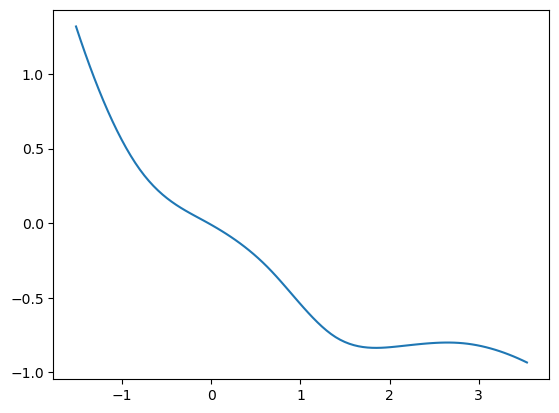

In [47]:
i = 12
XX = model.generate_X_grid(term=i)
plt.plot(XX[:,i],model.partial_dependence(term=i, X=XX))

In [49]:
mean, std

(0.8146952451279462, 0.051021657440709904)

In [50]:
from sklearn.datasets import load_breast_cancer

In [51]:
X, y = load_breast_cancer(return_X_y=True)

In [53]:
X.shape

(569, 30)

In [54]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,

In [56]:
load_df('breast','classification')

,Sample code number,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,target
0,1365328.0,1.0,1.0,2.0,1.0,2.0,0,2.0,1.0,1.0,0
1,242970.0,5.0,7.0,7.0,1.0,5.0,8,3.0,4.0,1.0,0
2,1133041.0,5.0,3.0,1.0,2.0,2.0,0,2.0,1.0,1.0,0
3,183936.0,3.0,1.0,1.0,1.0,2.0,0,2.0,1.0,1.0,0
4,1168278.0,3.0,1.0,1.0,1.0,2.0,0,2.0,1.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...
694,695091.0,5.0,10.0,10.0,5.0,4.0,5,4.0,4.0,1.0,1
695,837480.0,7.0,4.0,4.0,3.0,4.0,1,6.0,9.0,1.0,1
696,1057013.0,8.0,4.0,5.0,1.0,2.0,10,7.0,3.0,1.0,1
697,390840.0,8.0,4.0,7.0,1.0,3.0,1,3.0,9.0,2.0,1
